# 라이브러리 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import Transformer
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
# device 설정
# GPU사용 코드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CPU사용 코드
# device = torch.device("cpu")

# 1. 패혈증 중환자실 환자에 대한 사전학습 데이터셋 생성

- 입력 : 
  - 데이터셋 파일(data.csv)
  
| SUBJECT_ID | CHARTTIME  | 50803 | 50804 | 50805 | ... |
|------------|------------|-------|-------|-------|-----|
| 3          | 2101-10-04 | 1     | 0     | 0     | ... |
| 3          | 2101-10-05 | 1     | 0     | 0     | ... |
| 3          | 2101-10-06 | 1     | 0     | 0     | ... |
| 3          | 2101-10-07 | 1     | 0     | 0     | ... |
| 3          | 2101-10-11 | 1     | 0     | 0     | ... |
| 3          | 2101-10-12 | 1     | 0     | 0     | ... |

  
- 출력 : 
  - 환자 날짜 파일(DATEp.csv)  <데이터개수 N X 환자,날짜>

| ID | Date       |
|----|------------|
| 3  | 2101-10-13 |
| 3  | 2101-10-14 |
| 3  | 2101-10-15 |
| 3  | 2101-10-16 |
| 3  | 2101-10-17 |
| 3  | 2101-10-18 |

  - 사전학습 3차원 Xp 텐서 파일(Xp.pt)  <데이터개수 N X 시점수 T X 변수수 V>
  - 사전학습 3차원 Yp 텐서 파일(Yp.pt)  <데이터개수 N X 시점수 T X 변수수 V>

In [3]:
def read_date(line):
    return datetime.strptime(line.split(',')[1], "%Y-%m-%d")

def generate_tensors_from_csv(filename, seq_len=10):
    num_features = None
    lst_Xp = []
    lst_Yp = []
    lst_patient_date = []

    prev_patient_id = None
    prev_date = None
    buffer = []

    def process_buffer(buffer, num_features):
        if not buffer:
            return
        # 누락된 날짜 채우기
        full_dates = [buffer[0][1] + timedelta(days=i) for i in range((buffer[-1][1] - buffer[0][1]).days + 1)]
        full_data = []
        data_exist = []
        
        buffer_idx = 0
        for d in full_dates:
            if buffer_idx < len(buffer) and buffer[buffer_idx][1] == d:
                full_data.append(buffer[buffer_idx][2:])
                data_exist.append(True)
                buffer_idx += 1
            else:
                full_data.append([False] * num_features)
                data_exist.append(False)
        
        Xp_slices = []
        Yp_slices = []

        for i in range(len(full_data) - seq_len*2 + 1):
            ratio_Xp_exist = sum(data_exist[i:i+seq_len]) / seq_len
            ratio_Yp_exist = sum(data_exist[i+seq_len:i+seq_len*2]) / seq_len
            if ratio_Xp_exist >= 0.2 and ratio_Yp_exist >= 0.2:
                patient = buffer[0][0]
                date = full_dates[i+seq_len-1]
                lst_patient_date.append([patient, date.strftime("%Y-%m-%d")])
                Xp_slice = torch.tensor(full_data[i:i+seq_len], dtype=torch.bool)
                Yp_slice = torch.tensor(full_data[i+seq_len:i+seq_len*2], dtype=torch.bool)

                Xp_slices.append(Xp_slice)
                Yp_slices.append(Yp_slice)
            
        if Xp_slices != []:
            lst_Xp.extend(torch.stack(Xp_slices, dim=0))
            lst_Yp.extend(torch.stack(Yp_slices, dim=0))

    with open(filename, 'r') as file:
        header = file.readline()
        num_features = len(header.split(',')) - 2  # 환자ID와 날짜 제외

        for line in file:
            parts = line.strip().split(',')
            patient_id, date = parts[0], read_date(line)

            # 새로운 환자라면, 버퍼 처리 후 초기화
            if prev_patient_id is not None and prev_patient_id != patient_id:
                process_buffer(buffer, num_features)
                buffer = []

            buffer.append([patient_id, date] + [bool(int(float(val))) for val in parts[2:]])
            prev_patient_id = patient_id
            prev_date = date

        # 마지막 버퍼 처리하기
        if prev_patient_id is not None:
            process_buffer(buffer, num_features)

    Xp = torch.stack(lst_Xp, dim=0)
    Yp = torch.stack(lst_Yp, dim=0)    

    return lst_patient_date, Xp, Yp

data_file = 'data.csv'
lst_date, Xp, Yp = generate_tensors_from_csv(data_file, seq_len=10)
# 파일 저장 (torch.save 사용)
df = pd.DataFrame(lst_date, columns=['ID', 'Date'])
df.to_csv('DATEp.csv', index=False)
torch.save(Xp, 'Xp.pt')
torch.save(Yp, 'Yp.pt')
print(df.shape, Xp.shape, Yp.shape)

(112937, 2) torch.Size([112937, 10, 283]) torch.Size([112937, 10, 283])


# 2. 패혈증 중환자실 환자에 대한 전이학습 데이터셋 생성

- 입력 : 
  - 데이터셋 파일(data.csv)
  
| SUBJECT_ID | CHARTTIME  | 50803 | 50804 | 50805 | ... |
|------------|------------|-------|-------|-------|-----|
| 3          | 2101-10-04 | 1     | 0     | 0     | ... |
| 3          | 2101-10-05 | 1     | 0     | 0     | ... |
| 3          | 2101-10-06 | 1     | 0     | 0     | ... |
| 3          | 2101-10-07 | 1     | 0     | 0     | ... |
| 3          | 2101-10-11 | 1     | 0     | 0     | ... |
| 3          | 2101-10-12 | 1     | 0     | 0     | ... |

  - 라벨 파일(label.csv)
  
| SUBJECT_ID | DISCHARGE  | LABEL_DEAD1_ALIVE0 |
|------------|------------|--------------------|
| 3          | 2101-12-22 | 0                  |
| 3          | 2102-01-29 | 1                  |
| 21         | 2134-10-01 | 0                  |
| 21         | 2135-02-06 | 0                  |
| 33         | 2116-12-27 | 0                  |
| 38         | 2166-09-04 | 1                  |
| ...         | ... | ...                  |
  
- 출력 : 
  - 환자 날짜 파일(DATEt.csv)  <데이터개수 N X 환자,날짜>

| ID | Date       |
|----|------------|
| 3  | 2101-12-21 |
| 3  | 2102-01-28 |
| 21 | 2134-09-30 |
| 21 | 2135-02-05 |
| ... | ... |

  - 사전학습 3차원 Xt 텐서 파일(Xp.pt)  <데이터개수 N X 시점수 T X 변수수 V>
  - 사전학습 3차원 Yt 텐서 파일(Yp.pt)  <데이터개수 N X 1>

In [4]:
def read_date(line):
    return datetime.strptime(line.split(',')[1], "%Y-%m-%d")

def generate_tensors_from_csv(data_file, label_file, seq_len=10):

    # label_file 파일 읽기
    df = pd.read_csv(label_file, dtype=str)
    # (SUBJECT_ID, DISCHARGE)를 key로 하고, LABEL_DEAD1_ALIVE0를 value로 하는 dictionary 생성
    dic_pd2label = {(row['SUBJECT_ID'], row['DISCHARGE']): row['LABEL_DEAD1_ALIVE0'] for _, row in df.iterrows()}
    
    num_features = None
    lst_Xt = []
    lst_label = []
    lst_patient_date = []

    prev_patient_id = None
    prev_date = None
    buffer = []

    def process_buffer(buffer, num_features):
        if not buffer:  # 버퍼가 비어있는지 확인하기
            return
        # 누락된 날짜 채우기
        full_dates = [buffer[0][1] + timedelta(days=i) for i in range((buffer[-1][1] - buffer[0][1]).days + 1)]
        full_data = []
        data_exist = []
        
        buffer_idx = 0
        for d in full_dates:
            if buffer_idx < len(buffer) and buffer[buffer_idx][1] == d:
                full_data.append(buffer[buffer_idx][2:])
                data_exist.append(True)
                buffer_idx += 1
            else:
                full_data.append([False] * num_features)
                data_exist.append(False)
        
        Xt_slices = []

        for i in range(len(full_data) - seq_len + 1):
            patient = buffer[0][0]
            date = full_dates[i+seq_len-1]
            nextdate = date + timedelta(days=1)
            ratio_Xt_exist = sum(data_exist[i:i+seq_len]) / seq_len
            key = (patient, nextdate.strftime("%Y-%m-%d"))
            if key in dic_pd2label and ratio_Xt_exist >= 0.2:
                lst_patient_date.append([patient, date.strftime("%Y-%m-%d")])
                Xt_slice = torch.tensor(full_data[i:i+seq_len], dtype=torch.bool)

                Xt_slices.append(Xt_slice)
                lst_label.append(bool(int(dic_pd2label[key])))
            
        if Xt_slices != []:
            lst_Xt.extend(torch.stack(Xt_slices, dim=0))

    with open(data_file, 'r') as file:
        header = file.readline()
        num_features = len(header.split(',')) - 2  # 환자ID와 날짜 제외

        for line in file:
            parts = line.strip().split(',')
            patient_id, date = parts[0], read_date(line)

            # 새로운 환자라면, 버퍼 처리 후 초기화
            if prev_patient_id is not None and prev_patient_id != patient_id:
                process_buffer(buffer, num_features)
                buffer = []

            buffer.append([patient_id, date] + [bool(int(float(val))) for val in parts[2:]])
            prev_patient_id = patient_id
            prev_date = date

        # 마지막 버퍼 처리하기
        if prev_patient_id is not None:
            process_buffer(buffer, num_features)

    Xt = torch.stack(lst_Xt, dim=0)
    Yt = torch.tensor(lst_label).view(-1, 1)

    return lst_patient_date, Xt, Yt

data_file = 'data.csv'
label_file = 'label.csv'
lst_date, Xt, Yt = generate_tensors_from_csv(data_file, label_file, seq_len=10)
# 파일 저장 (torch.save 사용)
df = pd.DataFrame(lst_date, columns=['ID', 'Date'])
df.to_csv('DATEt.csv', index=False)
torch.save(Xt, 'Xt.pt')
torch.save(Yt, 'Yt.pt')
print(df.shape, Xt.shape, Yt.shape)
df

(6666, 2) torch.Size([6666, 10, 283]) torch.Size([6666, 1])


,ID,Date
0,3,2101-10-30
1,21,2134-09-23
2,38,2166-09-03
3,61,2118-07-19
4,61,2119-02-02
...,...,...
6661,99836,2116-07-16
6662,99865,2184-12-29
6663,99912,2153-04-26
6664,99985,2181-02-11


# 2. 사전학습

- 입력 : 
  - 사전학습 데이터셋 파일(Xp.pt, Yp.pt)
- 출력 : 
  - 사전학습된 트랜스포머 모델의 임베딩 모델 파일(pretrained_model_embedding.pth)
  - 사전학습된 트랜스포머 모델의 인코더 모델 파일(pretrained_model_encoder.pth)

In [5]:
# 사전 학습 데이터셋 Xp, Yp 로드
Xp = torch.load('Xp.pt')
Yp = torch.load('Yp.pt')
print(Xp.shape, Yp.shape)

# 사용자 정의 데이터셋
class PretrainDataset(Dataset):
    def __init__(self, Xp, Yp):
        self.Xp = Xp
        self.Yp = Yp

    def __len__(self):
        return len(self.Xp)

    def __getitem__(self, idx):
        return self.Xp[idx].float(), self.Yp[idx].float()

# 데이터로더 설정
batch_size = 32
train_dataset = PretrainDataset(Xp, Yp)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 트랜스포머 모델 정의
class PretrainTransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, output_dim):
        super(PretrainTransformerModel, self).__init__()
        # Embedding Layer 추가
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers)
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, src, tgt=None):
        if tgt is None:
            tgt = torch.zeros_like(src)
        src = self.embedding(src)  # Embedding Layer를 통과
        tgt = self.embedding(tgt)  # Embedding Layer를 통과        
        output = self.transformer(src, tgt)
        return self.fc(output)

    
# 모델, 손실함수, 옵티마이저 정의
imput_dim = Xp.shape[2]

model = PretrainTransformerModel(input_dim=imput_dim, d_model=128, nhead=128, num_encoder_layers=2, num_decoder_layers=2, output_dim=imput_dim).to(device)  # 간단한 설정으로 모델 초기화
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# 모델 훈련
epochs = 20

# 모델 훈련과 관련된 손실 값 저장
losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        # 데이터 차원 변경 (시간, 배치, 변수)
        batch_x = batch_x.permute(1, 0, 2) # (N, T, V) 형태에서 (T, N, V) 형태로 변경
        batch_y = batch_y.permute(1, 0, 2) # (N, T, V) 형태에서 (T, N, V) 형태로 변경
        
        # GPU/CPU 사용을 위한 데이터 이동
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # 순전파 및 오차계산
        output = model(batch_x, batch_y)
        loss = criterion(output, batch_y)
        
        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    # 평균 손실 계산
    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}')

# 인코더 저장
torch.save(model.embedding, 'pretrained_model_embedding.pth')
torch.save(model.transformer.encoder, 'pretrained_model_encoder.pth')

torch.Size([112937, 10, 283]) torch.Size([112937, 10, 283])
Epoch 1/20, Loss: 0.07743015494751651
Epoch 2/20, Loss: 0.010692891965570092
Epoch 3/20, Loss: 0.0028721536444064766
Epoch 4/20, Loss: 0.0008269123073240046
Epoch 5/20, Loss: 0.0002732257815497144
Epoch 6/20, Loss: 0.00010329297629012542
Epoch 7/20, Loss: 4.390558974411487e-05
Epoch 8/20, Loss: 2.066200845985428e-05
Epoch 9/20, Loss: 1.0732871767592406e-05
Epoch 10/20, Loss: 6.030213963244752e-06
Epoch 11/20, Loss: 3.7371973604005493e-06
Epoch 12/20, Loss: 2.3963454907113708e-06
Epoch 13/20, Loss: 1.820747383028711e-06
Epoch 14/20, Loss: 1.1567425622595733e-06
Epoch 15/20, Loss: 1.0961989671568099e-06
Epoch 16/20, Loss: 6.530940440992026e-07
Epoch 17/20, Loss: 5.805458304872389e-07
Epoch 18/20, Loss: 3.687780476861231e-07
Epoch 19/20, Loss: 2.9031829709336123e-07
Epoch 20/20, Loss: 3.0423059758724324e-07


- 손실 그래프 시각화

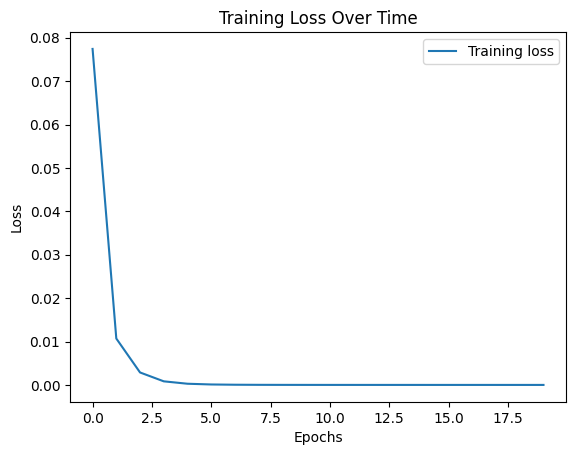

In [6]:
# 손실 그래프 시각화
plt.plot(losses, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

# 3. 전이학습

- 입력 : 
  - 전이학습 데이터셋 파일(Xt.pt, Yt.pt)
  - 사전학습된 트랜스포머 모델의 임베딩 모델 파일(pretrained_model_embedding.pth)
  - 사전학습된 트랜스포머 모델의 인코더 모델 파일(pretrained_model_encoder.pth)
- 출력 : 
  - 전이학습된 트랜스포머 모델의 모델 파일(transferred_model.pth)

In [7]:
# 전이학습 데이터셋 Xt, Yt 로드
Xt = torch.load('Xt.pt')
Yt = torch.load('Yt.pt')

class TransferDataset(Dataset):
    def __init__(self, Xt, Yt, type='all', train_size=None, shuffle=False, seed=None):
        self.Xt = Xt
        self.Yt = Yt
        self.type = type
        self.shuffle = shuffle
        self.train_size = train_size

        # 시드 설정 (설정된 경우)
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)

        if self.type == 'all':
            length = len(self.Xt)
        elif self.type == 'train':
            length = int(len(self.Xt) * self.train_size)
        elif self.type == 'test':
            length = int(len(self.Xt) * (1.0 - self.train_size))
        else:
            raise ValueError("Invalid type provided. Expected 'all', 'train', or 'test'.")
        
        self.length = length
        
        # shuffle이 True이면 랜덤 인덱스 생성
        if self.shuffle:
            self.indices = torch.randperm(len(self.Xt))
        else:
            self.indices = torch.arange(len(self.Xt))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if self.type == 'all':
            real_idx = self.indices[idx]
        elif self.type == 'train':
            real_idx = self.indices[idx]
        elif self.type == 'test':
            real_idx = self.indices[int(len(self.Xt) * self.train_size) + idx]
        return self.Xt[real_idx].float(), self.Yt[real_idx].float()
    
# 데이터로더 설정
batch_size = 32
train_dataset = TransferDataset(Xt, Yt, type='train', train_size=0.7, shuffle=True, seed=42)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class EncoderPredictionModel(nn.Module):
    def __init__(self, output_dim):
        super(EncoderPredictionModel, self).__init__()
        self.embedding = torch.load('pretrained_model_embedding.pth')
        self.encoder = torch.load('pretrained_model_encoder.pth')
        
        # embedding의 out_features로부터 d_model 추출
        d_model = self.embedding.out_features
        
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, src):
        out = self.embedding(src)  # Embedding Layer를 통과
        out = self.encoder(out)
        out = self.fc(out[-1, :, :])
        return torch.sigmoid(out)


# 모델 초기화
model = EncoderPredictionModel(output_dim=1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000028)

# 모델 훈련
epochs = 8

# 손실 값 저장 리스트 초기화
transfer_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for b, (batch_x, batch_y) in enumerate(train_loader):
        # 데이터 차원 변경 (시간, 배치, 변수)
        batch_x = batch_x.permute(1, 0, 2) # (N, T, V) 형태에서 (T, N, V) 형태로 변경
        
        # GPU/CPU 사용을 위한 데이터 이동
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # 순전파 및 오차계산
        output = model(batch_x)
        loss = criterion(output, batch_y)
        
        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    # 평균 손실 계산
    epoch_loss /= len(train_loader)
    transfer_losses.append(epoch_loss)
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}')

# 트랜스퍼 모델 저장
torch.save(model, 'transferred_model.pth')

Epoch 1/8, Loss: 0.49921774200788915
Epoch 2/8, Loss: 0.1970723586998982
Epoch 3/8, Loss: 0.17030115313317679
Epoch 4/8, Loss: 0.15827575940893937
Epoch 5/8, Loss: 0.156951523628341
Epoch 6/8, Loss: 0.1511547991699756
Epoch 7/8, Loss: 0.14689386774441354
Epoch 8/8, Loss: 0.14003052926073745


- 손실 그래프 시각화

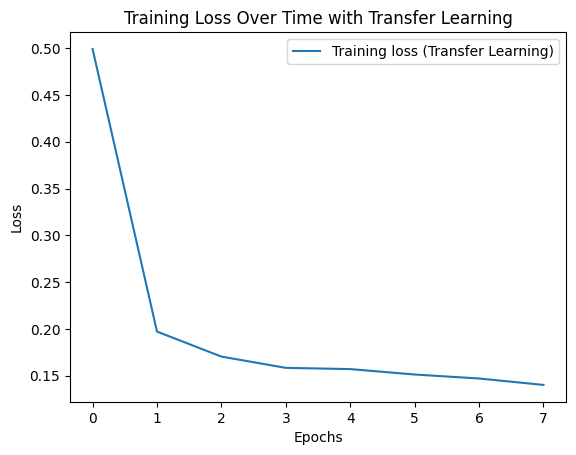

In [8]:
# 손실 그래프 시각화
plt.plot(transfer_losses, label='Training loss (Transfer Learning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time with Transfer Learning')
plt.legend()
plt.show()

# 4. 전이학습에 대한 예측 평가

- 입력 : 
  - 전이학습 데이터셋 파일(Xt.pt, Yt.pt)
  - 전이학습된 트랜스포머 모델의 모델 파일(transferred_model.pth)
- 출력 : 
  - 예측 정확도(ROC-AUC)

In [9]:
# 전이학습 데이터셋 Xt, Yt 로드
Xt = torch.load('Xt.pt')
Yt = torch.load('Yt.pt')

# 데이터로더 설정
batch_size = 32
test_dataset = TransferDataset(Xt, Yt, type='test', train_size=0.7, shuffle=True, seed=42)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# 트랜스퍼 모델 불러오기
model = torch.load('transferred_model.pth').to(device)

# 모델을 평가 모드로 설정
model.eval()

# 예측 및 실제 값을 저장하기 위한 리스트
all_preds = []
all_true = []

# 예측
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.permute(1, 0, 2)  # 시간, 배치, 변수 순서로 변경
        
        # GPU/CPU 사용을 위한 데이터 이동
        batch_x = batch_x.to(device)
        
        outputs = model(batch_x)
       
        all_preds.append(outputs.cpu().numpy())
        all_true.append(batch_y.numpy())

# 리스트 배열 Flatten
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

roc_auc = roc_auc_score(all_true, all_preds)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.9377503337783711


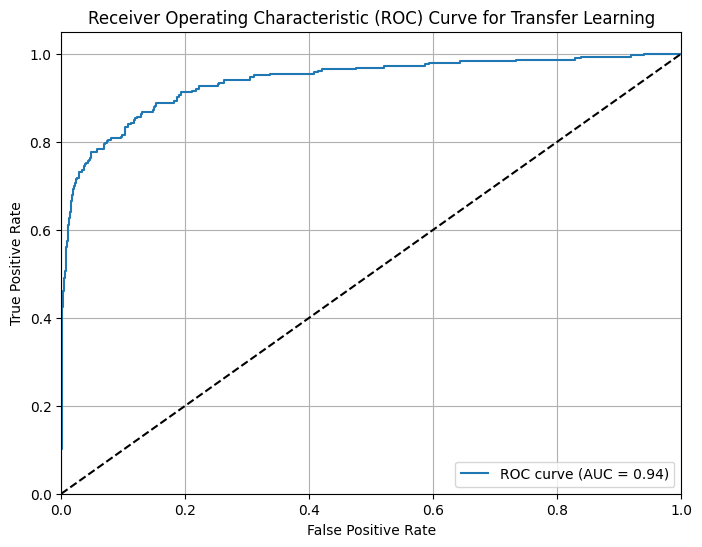

<function __main__.plot_roc_curve(all_true, all_preds)>

In [10]:
# ROC curve를 시각화하는 코드
def plot_roc_curve(all_true, all_preds):
    fpr, tpr, thresholds = roc_curve(all_true, all_preds)
    roc_auc = roc_auc_score(all_true, all_preds)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Transfer Learning')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_curve(all_true, all_preds)

plot_roc_curve